# Динамічне деформування балки з проміжною опорою

In [79]:
import matplotlib.pyplot as plt
from scipy.integrate import quad
import itertools
import numpy as np
import copy

## Однорідне рівняння: МПП

In [80]:
L = 10

In [81]:
def Krylov(index,varphi,s):    
    if index == 1:
        return (1.0/2)*(np.cosh(varphi*s) + np.cos(varphi*s))
    if index == 2:
        return (1.0/(2*varphi))*(np.sinh(varphi*s) + np.sin(varphi*s))
    if index == 3:
        return (1.0/(2*np.power(varphi,2)))*(np.cosh(varphi*s) - np.cos(varphi*s))
    if index == 4:
        return (1.0/(2*np.power(varphi,3)))*(np.sinh(varphi*s) - np.sin(varphi*s))

In [82]:
def homogeneous_equations(theta0,varphi):
    X = np.zeros(16)

    # beginning of element 1
    X[0] = 0
    X[1] = theta0
    X[2] = 0
    X[3] = X[1] * (-Krylov(2,varphi,L)/Krylov(4,varphi,L))

    # end of element 1
    X[4] = 0
    X[5] = X[1] * (Krylov(1,varphi,L) - Krylov(3,varphi,L)*Krylov(2,varphi,L)/Krylov(4,varphi,L))
    X[6] = X[1] * (np.power(varphi,4)*Krylov(4,varphi,L) - Krylov(2,varphi,L)*Krylov(2,varphi,L)/Krylov(4,varphi,L))
    X[7] = X[1] * (np.power(varphi,4)*Krylov(3,varphi,L) - Krylov(1,varphi,L)*Krylov(2,varphi,L)/Krylov(4,varphi,L))

    # beginning of element 2
    X[8] = 0
    X[9] = X[5]
    X[10] = X[6]
    X[11] = - X[9]*Krylov(2,varphi,L)/Krylov(4,varphi,L) - X[10]*Krylov(3,varphi,L)/Krylov(4,varphi,L)

    # end of element 2
    X[12] = 0   
    X[13] = X[9]*Krylov(1,varphi,L) + X[10]*Krylov(2,varphi,L) + X[11]*Krylov(3,varphi,L)
    X[14] = X[9]*np.power(varphi,4)*Krylov(4,varphi,L) + X[10]*Krylov(1,varphi,L) + X[11]*Krylov(2,varphi,L)
    X[15] = X[9]*np.power(varphi,4)*Krylov(3,varphi,L) + X[10]*np.power(varphi,4)*Krylov(4,varphi,L) + X[11]*Krylov(1,varphi,L)
   
    return X

In [83]:
def A_linear_independence(varphi):
    A = np.zeros((16,16))

    # field equations 1
    s = L
    A[0][4], A[0][0], A[0][1], A[0][2], A[0][3] = 1, -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s), -Krylov(4,varphi,s)
    A[1][5], A[1][0], A[1][1], A[1][2], A[1][3] = 1, -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s)
    A[2][6], A[2][0], A[2][1], A[2][2], A[2][3] = 1, -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s)
    A[3][7], A[3][0], A[3][1], A[3][2], A[3][3] = 1, -pow(varphi,4)*Krylov(2,varphi,s), -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s)

    # edge equations left
    A[4][0] = 1
    A[5][2] = 1

    # transition equations 1-2
    A[6][8], A[6][4] = 1, -1
    A[7][9], A[7][5] = 1, -1
    A[8][10], A[8][6] = 1, -1
    A[9][4] = 1

    # field equations 2
    s = 2*L
    A[10][12], A[10][8], A[10][9], A[10][10], A[10][11] = 1, -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s), -Krylov(4,varphi,s)
    A[11][13], A[11][8], A[11][9], A[11][10], A[11][11] = 1, -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s), -Krylov(3,varphi,s)
    A[12][14], A[12][8], A[12][9], A[12][10], A[12][11] = 1, -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s), -Krylov(2,varphi,s)
    A[13][15], A[13][8], A[13][9], A[13][10], A[13][11] = 1, -pow(varphi,4)*Krylov(2,varphi,s), -pow(varphi,4)*Krylov(3,varphi,s), -pow(varphi,4)*Krylov(4,varphi,s), -Krylov(1,varphi,s)

    # edge equations right
    A[14][12] = 1
    A[15][14] = 1

    return A

### Пошук власних чисел

In [84]:
step = 1e-4
w_candidates = np.arange(step, 1+step/2, step)

M2L = np.zeros(len(w_candidates))
theta0 = 1.0

w_zero_M2L = []
for i in range(len(w_candidates)):
    varphi = np.sqrt(w_candidates[i])
    X = homogeneous_equations(theta0,varphi)
    M2L[i] = X[14]

    if M2L[i] == 0:
        w_zero_M2L.append(w_candidates[i])

w_near_zero_M2L = [
    w_candidates[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(M2L[i] - 0) < np.abs(M2L[i-1] - 0) and np.abs(M2L[i] - 0) < np.abs(M2L[i+1] - 0)
]
near_zero_M2L = [
    M2L[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(M2L[i] - 0) < np.abs(M2L[i-1] - 0) and np.abs(M2L[i] - 0) < np.abs(M2L[i+1] - 0)
]

print("w_zero_M2L:", w_zero_M2L)
print("w_near_zero_M2L :", w_near_zero_M2L)
print("near_zero_M2L   :", near_zero_M2L)

w_zero_M2L: []
w_near_zero_M2L : [0.09870000000000001, 0.1542, 0.3948, 0.4996, 0.8883]
near_zero_M2L   : [-7.911471201960119e-05, 0.00033948043684173257, -0.00031644274166353625, -0.0009743919376887789, -0.0007119506140043086]


In [85]:
print("Max deviation of M2L:", max(near_zero_M2L))

Max deviation of M2L: 0.00033948043684173257


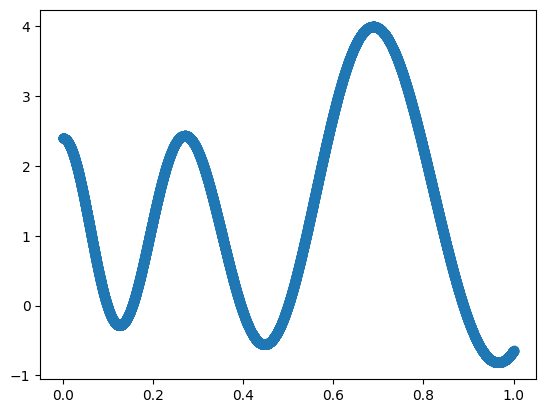

In [86]:
plt.plot(w_candidates, M2L, "o", linestyle="none")
# plt.ylim(-1,1)
plt.show()

In [87]:
# print("n w M2L")
# for i in range(len(w_candidates)):
#     print(i, w_candidates[i], M2L[i], end="\n")

### Пошук власних форм

In [88]:
w_1 = w_near_zero_M2L[0]
w_2 = w_near_zero_M2L[1]
w_3 = w_near_zero_M2L[2]
w_4 = w_near_zero_M2L[3]
w_5 = w_near_zero_M2L[4]

In [89]:
W_tmm = []

for w_i in [w_1,w_2,w_3,w_4,w_5]:
    varphi = np.sqrt(w_i)
    X = homogeneous_equations(theta0,varphi)

    print(f"\nw = {w_i}")
    print(f"W(s) = K2 + {X[3]}*K4, s in [0,L]")
    print(f"W(s) = {X[9]}*K2 + {X[10]}*K3 + {X[11]}*K4, s in [L,2L]")

    step = 0.01
    S = np.arange(0, 2*L+step/2, step)
    W_i = []

    for s in S:
        if 0 <= s <= L:
            W_i.append(X[1]*Krylov(2,varphi,s) + X[3]*Krylov(4,varphi,s))
        if L < s <= 2*L:
            W_i.append(X[9]*Krylov(2,varphi,s-L) + X[10]*Krylov(3,varphi,s-L) + X[11]*Krylov(4,varphi,s-L))
    
    W_tmm.append(copy.deepcopy(W_i))


w = 0.09870000000000001
W(s) = K2 + -0.09869892389754653*K4, s in [0,L]
W(s) = -0.9999313505291525*K2 + 3.9560071787958506e-05*K3 + 0.0986785973282282*K4, s in [L,2L]

w = 0.1542
W(s) = K2 + -0.14583651395664965*K4, s in [0,L]
W(s) = 0.0003142225461658654*K2 + 0.5401910858768959*K3 + -0.21233190668526486*K4, s in [L,2L]

w = 0.3948
W(s) = K2 + -0.3948003713063018*K4, s in [0,L]
W(s) = 0.9998745395986361*K2 + -0.0001582412238434472*K3 + -0.39465178217380464*K4, s in [L,2L]



w = 0.4996
W(s) = K2 + -0.5008046035721684*K4, s in [0,L]
W(s) = 0.00048697195342128907*K2 + -1.0004600170427693*K3 + 0.7069055945097764*K4, s in [L,2L]

w = 0.8883
W(s) = K2 + -0.8882999458497244*K4, s in [0,L]
W(s) = -0.9998110690130488*K2 + 0.0003560425743671658*K3 + 0.8877964953740061*K4, s in [L,2L]


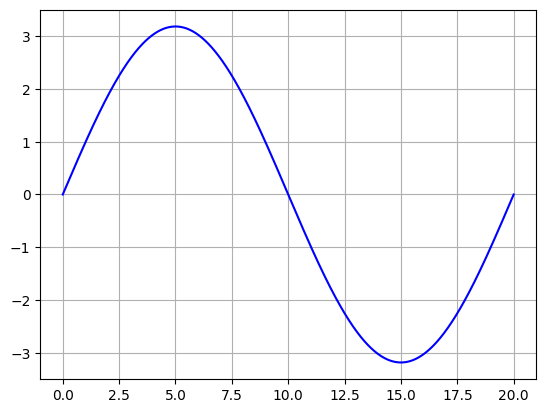

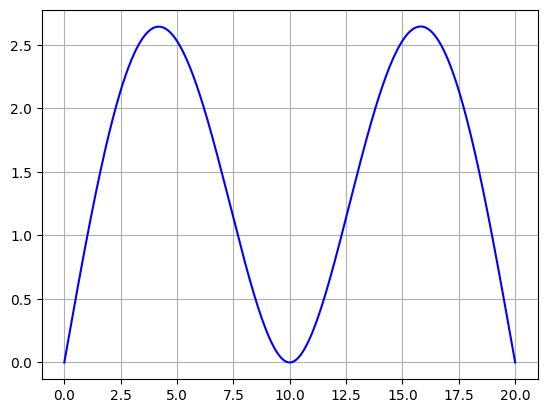

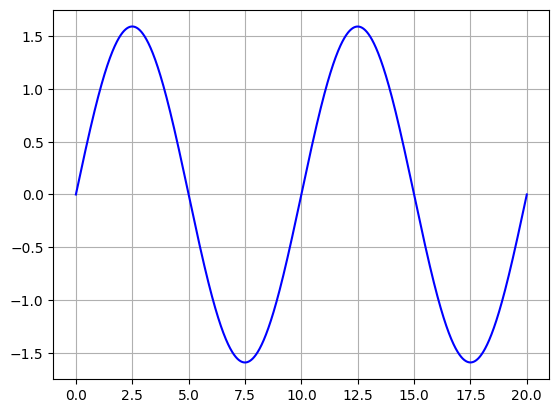

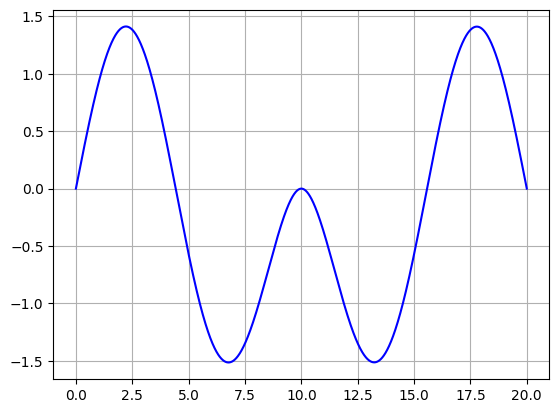

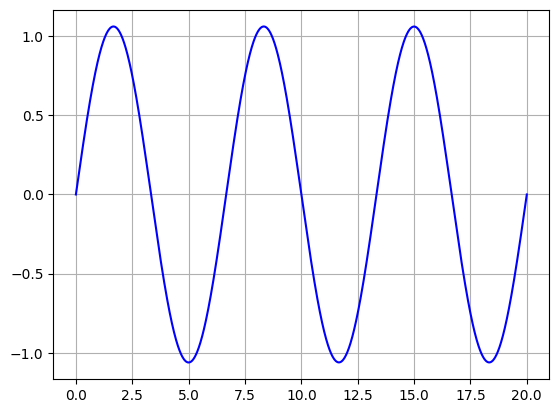

In [90]:
for i in range(len(W_tmm)):
    plt.plot(S, W_tmm[i], color='blue')
    plt.grid()
    plt.show()

In [91]:
# print("n s W(s)")
# for i in range(len(S)):
#     print(f"{i} {S[i]} {W_tmm[4][i]}")

## Однорідне рівняння: МЗЗ

Набір з $M=5$ базових функцій експоненціальної сім'ї:
\begin{align*}
    & \phi_1(s) = e^{-\frac{4s}{2L}} + A_{11}e^{-\frac{3s}{2L}} + A_{12}e^{-\frac{2s}{2L}} + A_{13}e^{-\frac{s}{2L}} + A_{14} \\
    & \phi_2(s) = e^{-\frac{3s}{2L}} + A_{21}e^{-\frac{2s}{2L}} + A_{22}e^{-\frac{s}{2L}} + A_{23} + A_{24}e^{\frac{s}{2L}} \\
    & \phi_3(s) = e^{-\frac{2s}{2L}} + A_{21}e^{-\frac{s}{2L}} + A_{22} + A_{23}e^{\frac{s}{2L}} + A_{24}e^{\frac{2s}{2L}} \\
    & \phi_4(s) = e^{-\frac{s}{2L}} + A_{21} + A_{22}e^{\frac{s}{2L}} + A_{23}e^{\frac{2s}{2L}} + A_{24}e^{\frac{3s}{2L}} \\
    & \phi_5(s) = 1 + A_{21}e^{\frac{s}{2L}} + A_{22}e^{\frac{2s}{2L}} + A_{23}e^{\frac{3s}{2L}} + A_{24}e^{\frac{4s}{2L}}
\end{align*}

### МЗЗ з двома базовими функціями

#### Задовільнення граничним умовам

In [92]:
A1 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-3), np.exp(-2), np.exp(-1), 1],
    [9, 4, 1, 0],
    [9*np.exp(-3), 4*np.exp(-2), np.exp(-1), 0],
])

B1 = np.array([-1, -np.exp(-4), -16, -16*np.exp(-4)])

A1_inv = np.linalg.inv(A1)
a1, b1, c1, d1 = np.dot(A1_inv,B1)

A2 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-2), np.exp(-1), 1, np.exp(1)],
    [4, 1, 0, 1],
    [4*np.exp(-2), np.exp(-1), 0, np.exp(1)],
])

B2 = np.array([-1, -np.exp(-3), -9, -9*np.exp(-3)])

A2_inv = np.linalg.inv(A2)
a2, b2, c2, d2 = np.dot(A2_inv,B2)

In [93]:
def phi_1(x):
    return np.exp(-(4*x)/(2*L)) + a1*np.exp(-(3*x)/(2*L)) + b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L)) + d1

def d4_phi_1(x):
    return (256*np.exp(-(4*x)/(2*L)) + 81*a1*np.exp(-(3*x)/(2*L)) + 16*b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L))) / (16*L**4)

def phi_2(x):
    return np.exp(-(3*x)/(2*L)) + a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + c2 + d2*np.exp(x/(2*L))

def d4_phi_2(x):
    return (81*np.exp(-(3*x)/(2*L)) + 16*a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + d2*np.exp(x/(2*L))) / (16*L**4)

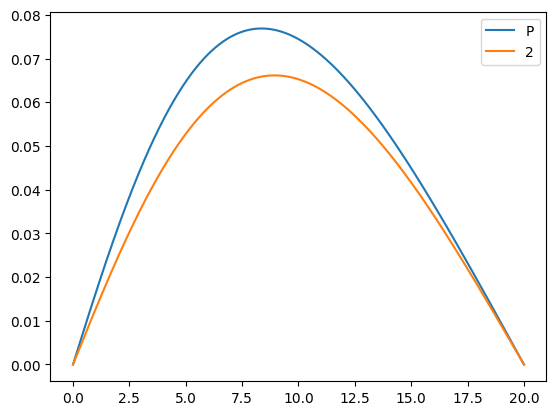

In [94]:
step = 0.01
S = np.arange(0, 2*L+step/2, step)

plt.plot(S,[phi_1(x) for x in S])
plt.legend("P1")

plt.plot(S,[phi_2(x) for x in S])
plt.legend("P2")
plt.show()

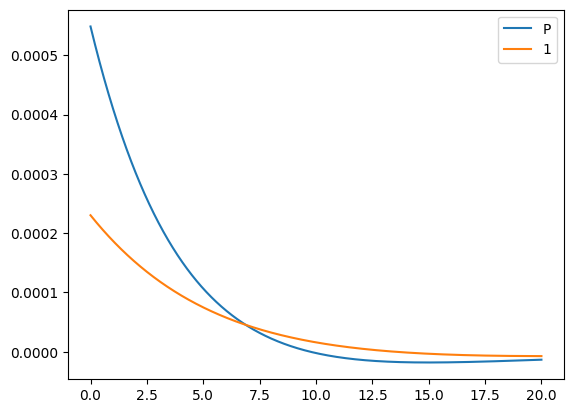

In [95]:
step = 0.01
S = np.arange(0, 2*L+step/2, step)

plt.plot(S,[d4_phi_1(x) for x in S])
plt.legend("P1")

plt.plot(S,[d4_phi_2(x) for x in S])
plt.legend("P1")
plt.show()

In [96]:
def integrand_11(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_1(x))

def integrand_21(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_1(x))

def integrand_12(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_2(x))

def integrand_22(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_2(x))

In [97]:
def calculate_integrads_2(w):
    I = np.zeros((3,3))

    I[1][1] = quad(integrand_11, 0, 2*L, args=w)[0]
    I[2][1] = quad(integrand_21, 0, 2*L, args=w)[0]
    I[1][2] = quad(integrand_12, 0, 2*L, args=w)[0]
    I[2][2] = quad(integrand_22, 0, 2*L, args=w)[0]

    return I

### Власні частоти

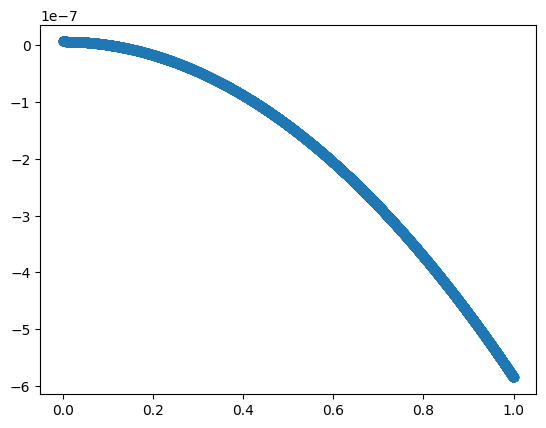

In [98]:
step = 1e-4
w_candidates = np.arange(0, 1+step/2, step)
determinant = np.zeros(len(w_candidates))

w_zero_determinant = []
for i in range(len(w_candidates)):
    I = calculate_integrads_2(w_candidates[i])

    U = np.array([
        [I[1][1], I[2][1], -phi_1(L)], 
        [I[1][2], I[2][2], -phi_2(L)],
        [phi_1(L), phi_2(L), 0]
    ])

    determinant[i] = np.linalg.det(U)
    if determinant[i] == 0:
        w_zero_determinant.append(w_candidates[i])

plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.show()

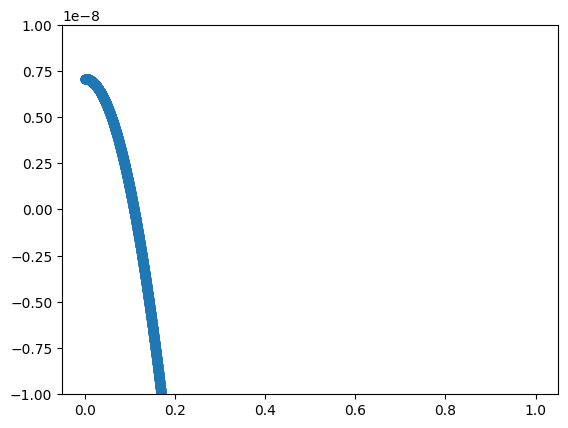

In [99]:
plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.ylim(-1e-8, 1e-8)
# plt.xlim(0,0.2)
plt.show()

In [100]:
w_near_zero_determinant = [
    w_candidates[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

near_zero_determinant = [
    determinant[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

print("w_near_zero_determinant :", w_near_zero_determinant)
print("near_zero_determinant   :", near_zero_determinant)

# w_near_zero_determinant : [0.10932000000000001]
# near_zero_determinant   : [4.566290988437135e-13]

w_near_zero_determinant : [0.10930000000000001]
near_zero_determinant   : [3.047304327518632e-12]


In [101]:
# print("n w det")
# for i in range(len(w_candidates)):
#     print(f"{i} {w_candidates[i]} {determinant[i]}")

### Власні форми

In [102]:
I = calculate_integrads_2(w_near_zero_determinant[0])
alpha1 = 1000

U = np.array([
    [I[2][1], -phi_1(L)], 
    # [I[2][2], -phi_2(L)],
    [phi_2(L), 0]
])

V = np.array([-alpha1*I[1][1], -alpha1*phi_1(L)])

U_inv = np.linalg.inv(U)
alpha2, Z = np.dot(U_inv,V)

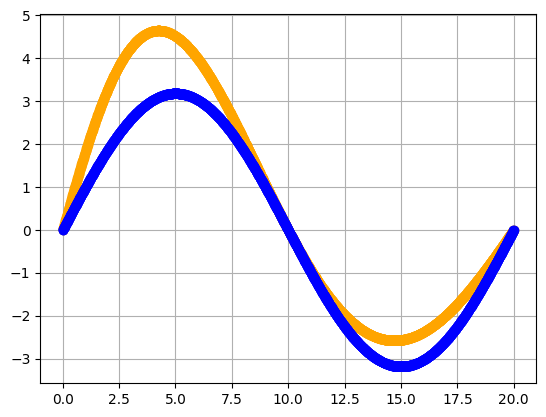

In [103]:
step = 0.01
S_wrm = np.arange(0, 2*L+step/2, step)
W_wrm_2 = np.array([alpha1*phi_1(s) + alpha2*phi_2(s) for s in S_wrm])

plt.plot(S_wrm, W_wrm_2, marker="o", color="orange")
plt.plot(S_wrm, W_tmm[0], marker="o", color="blue")
plt.grid()
plt.show()

In [ ]:
# print("n s W(s)")
# for i in range(len(S_wrm)):
#     print(f"{i} {S_wrm[i]} {W_wrm_2[i]}")

### МЗЗ з п'ятьма базовими функціями

#### Задовільнення граничним умовам

In [105]:
A1 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-3), np.exp(-2), np.exp(-1), 1],
    [9, 4, 1, 0],
    [9*np.exp(-3), 4*np.exp(-2), np.exp(-1), 0],
])

B1 = np.array([-1, -np.exp(-4), -16, -16*np.exp(-4)])

A1_inv = np.linalg.inv(A1)
a1, b1, c1, d1 = np.dot(A1_inv,B1)

A2 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-2), np.exp(-1), 1, np.exp(1)],
    [4, 1, 0, 1],
    [4*np.exp(-2), np.exp(-1), 0, np.exp(1)],
])

B2 = np.array([-1, -np.exp(-3), -9, -9*np.exp(-3)])

A2_inv = np.linalg.inv(A2)
a2, b2, c2, d2 = np.dot(A2_inv,B2)

A3 = np.array([
    [1, 1, 1, 1], 
    [np.exp(-1), 1, np.exp(1), np.exp(2)],
    [1, 0, 1, 4],
    [np.exp(-1), 0, np.exp(1), 4*np.exp(2)],
])

B3 = np.array([-1, -np.exp(-2), -4, -4*np.exp(-2)])

A3_inv = np.linalg.inv(A3)
a3, b3, c3, d3 = np.dot(A3_inv,B3)

A4 = np.array([
    [1, 1, 1, 1], 
    [1, np.exp(1), np.exp(2), np.exp(3)],
    [0, 1, 4, 9],
    [0, np.exp(1), 4*np.exp(2), 9*np.exp(3)],
])

B4 = np.array([-1, -np.exp(-1), -1, -np.exp(-1)])

A4_inv = np.linalg.inv(A4)
a4, b4, c4, d4 = np.dot(A4_inv,B4)

A5 = np.array([
    [1, 1, 1, 1], 
    [np.exp(1), np.exp(2), np.exp(3), np.exp(4)],
    [1, 4, 9, 16],
    [np.exp(1), 4*np.exp(2), 9*np.exp(3), 16*np.exp(4)],
])

B5 = np.array([-1, -1, 0, 0])

A5_inv = np.linalg.inv(A5)
a5, b5, c5, d5 = np.dot(A5_inv,B5)

In [106]:
def phi_1(x):
    return np.exp(-(4*x)/(2*L)) + a1*np.exp(-(3*x)/(2*L)) + b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L)) + d1

def d4_phi_1(x):
    return (256*np.exp(-(4*x)/(2*L)) + 81*a1*np.exp(-(3*x)/(2*L)) + 16*b1*np.exp(-(2*x)/(2*L)) + c1*np.exp(-x/(2*L))) / (16*L**4)

def phi_2(x):
    return np.exp(-(3*x)/(2*L)) + a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + c2 + d2*np.exp(x/(2*L))

def d4_phi_2(x):
    return (81*np.exp(-(3*x)/(2*L)) + 16*a2*np.exp(-(2*x)/(2*L)) + b2*np.exp(-x/(2*L)) + d2*np.exp(x/(2*L))) / (16*L**4)

def phi_3(x):
    return np.exp(-(2*x)/(2*L)) + a3*np.exp(-x/(2*L)) + b3 + c3*np.exp(x/(2*L)) + d3*np.exp((2*x)/(2*L))

def d4_phi_3(x):
    return (16*np.exp(-(2*x)/(2*L)) + a3*np.exp(-x/(2*L)) + c3*np.exp(x/(2*L)) + 16*d3*np.exp((2*x)/(2*L))) / (16*L**4)

def phi_4(x):
    return np.exp(-x/(2*L)) + a4 + b4*np.exp(x/(2*L)) + c4*np.exp((2*x)/(2*L)) + d4*np.exp((3*x)/(2*L))

def d4_phi_4(x):
    return (np.exp(-x/(2*L)) + b4*np.exp(x/(2*L)) + 16*c4*np.exp((2*x)/(2*L)) + 81*d4*np.exp((3*x)/(2*L))) / (16*L**4)

def phi_5(x):
    return 1 + a5*np.exp(x/(2*L)) + b5*np.exp((2*x)/(2*L)) + c5*np.exp((3*x)/(2*L)) + d5*np.exp((4*x)/(2*L))

def d4_phi_5(x):
    return (a5*np.exp(x/(2*L)) + 16*b5*np.exp((2*x)/(2*L)) + 81*c5*np.exp((3*x)/(2*L)) + 256*d5*np.exp((4*x)/(2*L))) / (16*L**4)

In [107]:
def integrand_11(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_1(x))

def integrand_21(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_1(x))

def integrand_31(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_1(x))

def integrand_41(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_1(x))

def integrand_51(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_1(x))

def integrand_12(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_2(x))

def integrand_22(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_2(x))

def integrand_32(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_2(x))

def integrand_42(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_2(x))

def integrand_52(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_2(x))

def integrand_13(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_3(x))

def integrand_23(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_3(x))

def integrand_33(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_3(x))

def integrand_43(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_3(x))

def integrand_53(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_3(x))

def integrand_14(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_4(x))

def integrand_24(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_4(x))

def integrand_34(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_4(x))

def integrand_44(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_4(x))

def integrand_54(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_4(x))

def integrand_15(x,w):
    return (d4_phi_1(x) - np.power(w,2)*phi_1(x)) * (phi_5(x))

def integrand_25(x,w):
    return (d4_phi_2(x) - np.power(w,2)*phi_2(x)) * (phi_5(x))

def integrand_35(x,w):
    return (d4_phi_3(x) - np.power(w,2)*phi_3(x)) * (phi_5(x))

def integrand_45(x,w):
    return (d4_phi_4(x) - np.power(w,2)*phi_4(x)) * (phi_5(x))

def integrand_55(x,w):
    return (d4_phi_5(x) - np.power(w,2)*phi_5(x)) * (phi_5(x))

In [108]:
def calculate_integrads(w):
    I = np.zeros((6,6))

    I[1][1] = quad(integrand_11, 0, 2*L, args=w)[0]
    I[2][1] = quad(integrand_21, 0, 2*L, args=w)[0]
    I[3][1] = quad(integrand_31, 0, 2*L, args=w)[0]
    I[4][1] = quad(integrand_41, 0, 2*L, args=w)[0]
    I[5][1] = quad(integrand_51, 0, 2*L, args=w)[0]

    I[1][2] = quad(integrand_12, 0, 2*L, args=w)[0]
    I[2][2] = quad(integrand_22, 0, 2*L, args=w)[0]
    I[3][2] = quad(integrand_32, 0, 2*L, args=w)[0]
    I[4][2] = quad(integrand_42, 0, 2*L, args=w)[0]
    I[5][2] = quad(integrand_52, 0, 2*L, args=w)[0]

    I[1][3] = quad(integrand_13, 0, 2*L, args=w)[0]
    I[2][3] = quad(integrand_23, 0, 2*L, args=w)[0]
    I[3][3] = quad(integrand_33, 0, 2*L, args=w)[0]
    I[4][3] = quad(integrand_43, 0, 2*L, args=w)[0]
    I[5][3] = quad(integrand_53, 0, 2*L, args=w)[0]

    I[1][4] = quad(integrand_14, 0, 2*L, args=w)[0]
    I[2][4] = quad(integrand_24, 0, 2*L, args=w)[0]
    I[3][4] = quad(integrand_34, 0, 2*L, args=w)[0]
    I[4][4] = quad(integrand_44, 0, 2*L, args=w)[0]
    I[5][4] = quad(integrand_54, 0, 2*L, args=w)[0]

    I[1][5] = quad(integrand_15, 0, 2*L, args=w)[0]
    I[2][5] = quad(integrand_25, 0, 2*L, args=w)[0]
    I[3][5] = quad(integrand_35, 0, 2*L, args=w)[0]
    I[4][5] = quad(integrand_45, 0, 2*L, args=w)[0]
    I[5][5] = quad(integrand_55, 0, 2*L, args=w)[0]

    return I

In [109]:
# print("n s phi1 d4_phi1 phi2 d4_phi2 phi3 phi4 phi5")
# for i in range(len(S)):
#     print(f"{i} {S[i]} {phi_1(S[i])} {d4_phi_1(S[i])} {phi_2(S[i])} {d4_phi_2(S[i])} {phi_3(S[i])} {phi_4(S[i])} {phi_5(S[i])}")

### Власні частоти

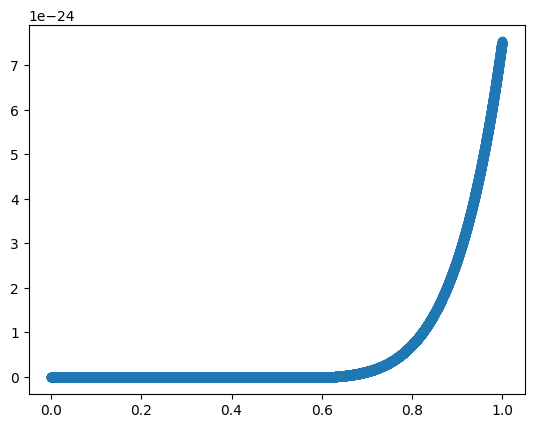

In [110]:
step = 1e-4
w_candidates = np.arange(0, 1+step/2, step)
determinant = np.zeros(len(w_candidates))

w_zero_determinant = []
for i in range(len(w_candidates)):
    I = calculate_integrads(w_candidates[i])

    U = np.array([
        [I[1][1], I[2][1], I[3][1], I[4][1], I[5][1], -phi_1(L)], 
        [I[1][2], I[2][2], I[3][2], I[4][2], I[5][2], -phi_2(L)],
        [I[1][3], I[2][3], I[3][3], I[4][3], I[5][3], -phi_3(L)],
        [I[1][4], I[2][4], I[3][4], I[4][4], I[5][4], -phi_4(L)],
        [I[1][5], I[2][5], I[3][5], I[4][5], I[5][5], -phi_5(L)],
        [phi_1(L), phi_2(L), phi_3(L), phi_4(L), phi_5(L), 0]
    ])

    determinant[i] = np.linalg.det(U)
    if determinant[i] == 0:
        w_zero_determinant.append(w_candidates[i])

plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.show()

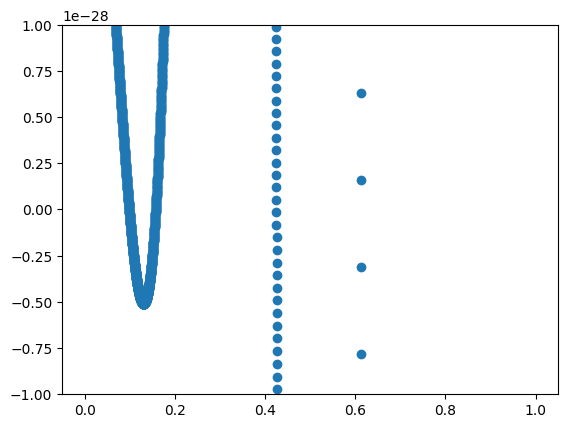

In [111]:
plt.plot(w_candidates, determinant, "o", linestyle="none")
plt.ylim(-1e-28, 1e-28)
# plt.xlim(0, 0.3)
plt.show()

In [112]:
w_near_zero_determinant = [
    w_candidates[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

near_zero_determinant = [
    determinant[i] for i in range(1,len(w_candidates)-1) 
    if np.abs(determinant[i] - 0) < np.abs(determinant[i-1] - 0) and np.abs(determinant[i] - 0) < np.abs(determinant[i+1] - 0)
]

print("w_near_zero_determinant :", w_near_zero_determinant)
print("near_zero_determinant   :", near_zero_determinant)

# w_near_zero_determinant : [0.09870000000000001, 0.15760000000000002, 0.4253, 0.6132000000000001]
# near_zero_determinant   : [1.5911698675322045e-32, 7.676663481929845e-32, -1.582870080726748e-30, 1.5750385299132378e-29]

w_near_zero_determinant : [0.09870000000000001, 0.15760000000000002, 0.4253, 0.6132000000000001]
near_zero_determinant   : [1.5911698675322045e-32, 7.676663481929845e-32, -1.582870080726748e-30, 1.5750385299132378e-29]


In [113]:
# print("n w det")
# for i in range(len(w_candidates)):
#     print(f"{i} {w_candidates[i]} {determinant[i]}")

In [114]:
# print("n w det")
# for i in range(len(w_candidates)):
#     if -1.2e-28 < determinant[i] < 1.2e-28:
#         print(f"{i} {w_candidates[i]} {determinant[i]}")

### Власні форми

In [115]:
F = 4

I = calculate_integrads(w_near_zero_determinant[F-1])
alpha1 = 60000

U = np.array([
    [I[2][1], I[3][1], I[4][1], I[5][1], -phi_1(L)], 
    [I[2][2], I[3][2], I[4][2], I[5][2], -phi_2(L)],
    [I[2][3], I[3][3], I[4][3], I[5][3], -phi_3(L)],
    [I[2][4], I[3][4], I[4][4], I[5][4], -phi_4(L)],
    # [I[2][5], I[3][5], I[4][5], I[5][5], -phi_5(L)],
    [phi_2(L), phi_3(L), phi_4(L), phi_5(L), 0],
])

V = np.array([-alpha1*I[1][1], -alpha1*I[1][2], -alpha1*I[1][3], -alpha1*I[1][4], -alpha1*phi_1(L)])

U_inv = np.linalg.inv(U)
alpha2, alpha3, alpha4, alpha5, Z = np.dot(U_inv,V)

In [116]:
step = 0.01
S_wrm = np.arange(0, 2*L+step/2, step)

W_wrm_5 = np.array([alpha1*phi_1(s) + alpha2*phi_2(s) + alpha3*phi_3(s) + alpha4*phi_4(s) + alpha5*phi_5(s) for s in S_wrm])

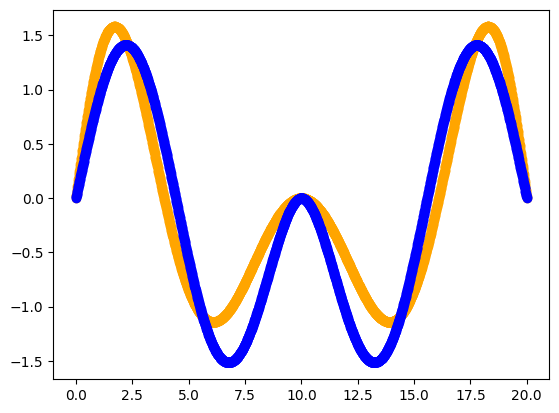

In [117]:
plt.plot(S_wrm,W_wrm_5,marker='o',color='orange')
plt.grid()

plt.plot(S_wrm,W_tmm[F-1],marker='o',color='blue')
plt.grid()

plt.show()

### Обчислення відмінностей між формами за МПП та за МЗЗ

In [118]:
error_abs = np.array([
    abs((W_wrm_5[i]-W_tmm[F-1][i])/W_tmm[F-1][i]) for i in range(len(S_wrm)) if W_tmm[F-1][i] != 0.0]
)

deviations = np.where(error_abs > 1)[0]
print(f"Deviations: {deviations}" if len(np.where(error_abs > 1)[0]) > 0 else "\nZero deviations")
error = np.mean(np.delete(error_abs, deviations))

print(f"\nВідносна похибка обчсилень: {round(error*100,4)}%")

Deviations: [ 390  391  392  393  394  395  396  397  398  399  400  401  402  403
  404  405  406  407  408  409  410  411  412  413  414  415  416  417
  418  419  420  421  422  423  424  425  426  427  428  429  430  431
  432  433  434  435  436  437  438  439  440  441  442  443  444  445
  446  447  448  449  450  451  452  453  454  455  456  457  458  459
  460  461  462  463  464  465  466  467  468  469  470  471  472  473
  474  475  476  477  999 1522 1523 1524 1525 1526 1527 1528 1529 1530
 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544
 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558
 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572
 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586
 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600
 1601 1602 1603 1604 1605 1606 1607 1608 1999]

Відносна похибка обчсилень: 38.2685%


In [119]:
# print("n s W(s)")
# for i in range(len(S_wrm)):
#     print(f"{i} {S[i]} {W_wrm_5[i]}")